# 06 Nonlinear classifiers

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [2]:
# Some global variables
features_basepath = '/data/ml_course/04_Applied_Machine_Learning_2/11_Course_project/'

In [3]:
# Load data
def load_data(features_basepath, features_file, one_hot_encoding=False):
    with np.load(os.path.join(features_basepath, features_file), allow_pickle=False) as npz_file:
        data = dict(npz_file.items())
        
    X = data['data']
    if one_hot_encoding:
        y = data['labels']
    else:
        y = np.where(data['labels'] == 1)[1]
    names = data['names']
    filenames = data['filenames']
    
    return X, y, names, filenames 

In [4]:
X_tr, y_tr, names, fn_tr = load_data(features_basepath, 'Swissroads_train.npz', one_hot_encoding=False)
X_va, y_va, _, fn_va = load_data(features_basepath, 'Swissroads_valid.npz', one_hot_encoding=False)
X_te, y_te, _, fn_te = load_data(features_basepath, 'Swissroads_test.npz', one_hot_encoding=False)
print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)
print(X_te.shape, y_te.shape)

(280, 1280) (280,)
(139, 1280) (139,)
(50, 1280) (50,)


In [5]:
X = np.append(X_tr, X_va, axis=0)
y = np.append(y_tr, y_va, axis=0)
print(X.shape, y.shape)

(419, 1280) (419,)


In [6]:
# Create 5 test folds
n_folds = 5
n_tr = y_tr.shape[0]
n_va = int(y_va.shape[0]/n_folds)
test_fold = np.zeros(y.shape[0])
test_fold[:n_tr] = -1

test_fold[n_tr:n_tr+n_va] = 0
test_fold[n_tr+n_va:n_tr+2*n_va] = 1
test_fold[n_tr+2*n_va:n_tr+3*n_va] = 2
test_fold[n_tr+3*n_va:n_tr+4*n_va] = 3
test_fold[n_tr+4*n_va:] = 4

# create five folds with the validation data
ps = PredefinedSplit(test_fold)
ps.get_n_splits()

5

## Random Forest

In [7]:
# Create pipeline
pipe_RF = Pipeline([
    ('scaler', None),
    ('RF', RandomForestClassifier(random_state=0, max_depth=None))
])

# Create cross-validation object
n_estimators = np.r_[np.arange(1, 101), np.arange(150, 1001, 50)]
grid_RF = {'RF__n_estimators': n_estimators}

grid_RF_cv = GridSearchCV(pipe_RF, grid_RF, cv=ps, return_train_score=True, verbose=True, n_jobs=-1)

# Fit estimator
grid_RF_cv.fit(X, y)

Fitting 5 folds for each of 118 candidates, totalling 590 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 167 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 590 out of 590 | elapsed:  1.2min finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  4,  4])),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'RF__n_estimators': array([   1,    2, ...,  950, 1000])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [8]:
# Collect results in a DataFrame
RF_results = pd.DataFrame({
    'trees': grid_RF_cv.cv_results_['param_RF__n_estimators'],
    'mean_tr': grid_RF_cv.cv_results_['mean_train_score'],
    'mean_te': grid_RF_cv.cv_results_['mean_test_score'],
    'std_te': grid_RF_cv.cv_results_['std_test_score']
})

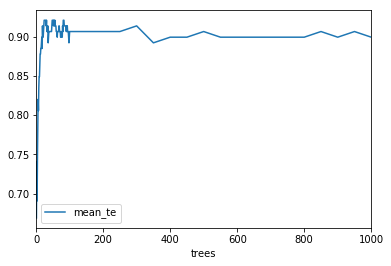

In [9]:
# Plot test curve
RF_results.plot(x='trees', y='mean_te')
plt.show()

In [10]:
# Ten best combinations according to the mean test score
RF_results.sort_values(by='mean_te', ascending=False).head(10)

,trees,mean_tr,mean_te,std_te
27,28,1.0,0.920863,0.043127
48,49,1.0,0.920863,0.036428
25,26,1.0,0.920863,0.028180
24,25,1.0,0.920863,0.028180
23,24,1.0,0.920863,0.028180
28,29,1.0,0.920863,0.043127
30,31,1.0,0.920863,0.043127
55,56,1.0,0.920863,0.058810
47,48,1.0,0.920863,0.036428
26,27,1.0,0.920863,0.028180


In [11]:
# Report test score
acc_RF = 100*grid_RF_cv.score(X_te, y_te)
print('Test accuracy: {:.2f}%'.format(acc_RF))

Test accuracy: 92.00%


## linear SVM

In [12]:
# Create pipeline
pipe_lSVM = Pipeline([
    ('scaler', None),
    ('lSVM', LinearSVC())
])

# Create cross-validation object
Cs = np.logspace(-4, 4, num=20)
grid_lSVM = {'lSVM__C': Cs}

grid_lSVM_cv = GridSearchCV(pipe_lSVM, grid_lSVM, cv=ps, return_train_score=True, verbose=True, n_jobs=-1)

# Fit estimator
grid_lSVM_cv.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  4,  4])),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('lSVM', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'lSVM__C': array([1.00000e-04, 2.63665e-04, 6.95193e-04, 1.83298e-03, 4.83293e-03,
       1.27427e-02, 3.35982e-02, 8.85867e-02, 2.33572e-01, 6.15848e-01,
       1.62378e+00, 4.28133e+00, 1.12884e+01, 2.97635e+01, 7.84760e+01,
       2.06914e+02, 5.45559e+02, 1.43845e+03, 3.79269e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [13]:
# Collect results in a DataFrame
lSVM_results = pd.DataFrame({
    'C': grid_lSVM_cv.cv_results_['param_lSVM__C'],
    'mean_tr': grid_lSVM_cv.cv_results_['mean_train_score'],
    'mean_te': grid_lSVM_cv.cv_results_['mean_test_score'],
    'std_te': grid_lSVM_cv.cv_results_['std_test_score']
})

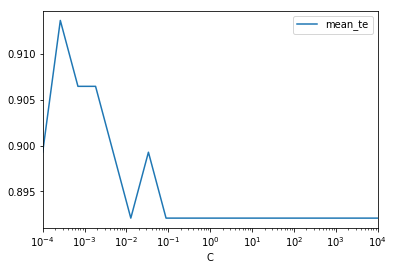

In [14]:
# Plot test curve
lSVM_results.plot(x='C', y='mean_te', logx=True)
plt.show()

In [15]:
# Ten best combinations according to the mean test score
lSVM_results.sort_values(by='mean_te', ascending=False).head(10)

,C,mean_tr,mean_te,std_te
1,0.000263665,0.940180,0.913669,0.058554
2,0.000695193,0.975463,0.906475,0.060323
3,0.00183298,0.992847,0.906475,0.060323
0,0.0001,0.908505,0.899281,0.064082
4,0.00483293,0.996934,0.899281,0.064082
6,0.0335982,1.000000,0.899281,0.053562
13,29.7635,1.000000,0.892086,0.061367
18,3792.69,1.000000,0.892086,0.061367
17,1438.45,1.000000,0.892086,0.061367
16,545.559,1.000000,0.892086,0.061367


In [16]:
# Report test score
acc_lSVM = 100*grid_lSVM_cv.score(X_te, y_te)
print('Test accuracy: {:.2f}%'.format(acc_lSVM))

Test accuracy: 96.00%


## SVM with RBF kernel

In [17]:
# Create pipeline
pipe_SVM = Pipeline([
    ('scaler', None),
    ('SVM', SVC(kernel='rbf'))
])

# Create cross-validation object
Cs = np.logspace(-4, 4, num=20)
gammas = np.logspace(-4, 4, num=20)
grid_SVM = {
    'SVM__C': Cs,
    'SVM__gamma': gammas}

grid_SVM_cv = GridSearchCV(pipe_SVM, grid_SVM, cv=ps, return_train_score=True, verbose=True, n_jobs=-1)

# Fit estimator
grid_SVM_cv.fit(X, y)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  5.5min finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  4,  4])),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'SVM__C': array([1.00000e-04, 2.63665e-04, 6.95193e-04, 1.83298e-03, 4.83293e-03,
       1.27427e-02, 3.35982e-02, 8.85867e-02, 2.33572e-01, 6.15848e-01,
       1.62378e+00, 4.28133e+00, 1.12884e+01, 2.97635e+01, 7.84760e+01,
       2.06914e+02, 5.45559e+02, 1.43845e+03, 3.79269e+03, 1.0... 2.97635e+01, 7.84760e+01,
       2.06914e+02, 5.45559e+02, 1.43845e+03, 3.79269e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [18]:
# Collect results in a DataFrame
SVM_results = pd.DataFrame({
    'C': grid_SVM_cv.cv_results_['param_SVM__C'],
    'gamma': grid_SVM_cv.cv_results_['param_SVM__gamma'],
    'mean_tr': grid_SVM_cv.cv_results_['mean_train_score'],
    'mean_te': grid_SVM_cv.cv_results_['mean_test_score'],
    'std_te': grid_SVM_cv.cv_results_['std_test_score']
})

# Ten best combinations according to the mean test score
SVM_results.sort_values(by='mean_te', ascending=False).head(10)

,C,gamma,mean_tr,mean_te,std_te
220,4.28133,0.0001,0.946313,0.928058,0.041445
201,1.62378,0.000263665,0.945287,0.928058,0.041445
202,1.62378,0.000695193,0.979544,0.920863,0.048917
221,4.28133,0.000263665,0.981086,0.913669,0.050346
240,11.2884,0.0001,0.981596,0.913669,0.050346
182,0.615848,0.000695193,0.944283,0.913669,0.050346
301,206.914,0.000263665,1.000000,0.906475,0.038823
381,10000,0.000263665,1.000000,0.906475,0.038823
380,10000,0.0001,1.000000,0.906475,0.038823
360,3792.69,0.0001,1.000000,0.906475,0.038823


In [19]:
# Report test score
acc_SVM = 100*grid_SVM_cv.score(X_te, y_te)
print('Test accuracy: {:.2f}%'.format(acc_SVM))

Test accuracy: 96.00%


SVM with RBF kernel does not perform better than linear SVM 

## Store results

In [20]:
df_acc = pd.DataFrame(
    {'model': ['random forest', 'svm linear', 'svm rbf'], 'test_accuracy': [acc_RF, acc_lSVM, acc_SVM]})
df_acc.to_csv('acc_non-linear_models.csv', index=False)